# **1.) Clipping vs. no clipping**

# **2.) First EMI, then z-transform vs. z-transform, them EMI**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

In [2]:
subreddits = ['Ask_Politics' , 'Askpolitics', 'PoliticalDiscussion', 'PoliticalDebate', 'NeutralPolitics','politics']

subreddits_reduced = ['Ask_Politics' , 'Askpolitics', 'PoliticalDiscussion', 'PoliticalDebate', 'NeutralPolitics']


In [3]:
clipped_dict = {}

for subr in subreddits:
    clipped_dict[subr] = pd.read_csv(f"output_clipped/{subr}_EMI.csv")
    
    # drop labels --> not final ones!
    clipped_dict[subr] = clipped_dict[subr].drop(columns = ["predictions_score_ft", "predictions_ft"])
    


    

In [4]:
non_clipped_dict = {}

for subr in subreddits:
    non_clipped_dict[subr] = pd.read_csv(f"output_non_clipped/{subr}_EMI.csv")

    # drop labels --> not final ones!
    non_clipped_dict[subr] = non_clipped_dict[subr].drop(columns = ["predictions_score_ft", "predictions_ft"])
    
    

# **1.) Clipped vs. non-Clipped**

In [5]:
# clipping makes some interactions, were a score can get empty --> drop

lost_interactions_overall = 0
OG_nr_interactions = 0
left_nr_interactions = 0

for subr in subreddits:

    if len(clipped_dict[subr]) == len(non_clipped_dict[subr]):
        OG_len = len(clipped_dict[subr])
        print(f"{subr}: OG_len {OG_len}")
    else:
        print(f"{subr}: clipped and non-clipped version have not the same length")

    # drop empty interactions from clipped version
    clipped_dict[subr] = clipped_dict[subr].dropna().reset_index(drop = True)
    print(f"After removing empty interactions, {subr} has {len(clipped_dict[subr])} interactions left.")
    print(f"Lost nr: {OG_len - len(clipped_dict[subr])}")
    print(f"Lost share: {(OG_len - len(clipped_dict[subr])) / OG_len}")

    # restrict non-clipped to retained rows
    non_clipped_dict[subr] = non_clipped_dict[subr][non_clipped_dict[subr]["msg_id_child"].isin(clipped_dict[subr]["msg_id_child"])]
    print(f"Non-clipped df len: {len(non_clipped_dict[subr])}")

    lost_interactions_overall += (OG_len - len(clipped_dict[subr]))
    OG_nr_interactions += OG_len
    left_nr_interactions += len(clipped_dict[subr])
    
    print("---------------------------------")

Ask_Politics: OG_len 54203
After removing empty interactions, Ask_Politics has 54203 interactions left.
Lost nr: 0
Lost share: 0.0
Non-clipped df len: 54203
---------------------------------
Askpolitics: OG_len 6354
After removing empty interactions, Askpolitics has 6354 interactions left.
Lost nr: 0
Lost share: 0.0
Non-clipped df len: 6354
---------------------------------
PoliticalDiscussion: OG_len 667335
After removing empty interactions, PoliticalDiscussion has 667335 interactions left.
Lost nr: 0
Lost share: 0.0
Non-clipped df len: 667335
---------------------------------
PoliticalDebate: OG_len 8738
After removing empty interactions, PoliticalDebate has 8738 interactions left.
Lost nr: 0
Lost share: 0.0
Non-clipped df len: 8738
---------------------------------
NeutralPolitics: OG_len 45221
After removing empty interactions, NeutralPolitics has 45221 interactions left.
Lost nr: 0
Lost share: 0.0
Non-clipped df len: 45221
---------------------------------
politics: OG_len 4171700

In [6]:
print(lost_interactions_overall) 
print(OG_nr_interactions)
print(left_nr_interactions)

print(lost_interactions_overall / OG_nr_interactions)
print(left_nr_interactions / OG_nr_interactions)

831665
4953551
4121886
0.16789268950698197
0.832107310493018


In [9]:
def plot_clipped_vs_non_clipped(clipped_dict, non_clipped_dict, model_type='finetuned', order='len_EMI_z_trans'):

    # Define the desired text type order and labels
    text_types_ordered = [
        ('submission', 'submission_id', 'Submission'),
        ('parent', 'msg_id_parent', 'Comment'),
        ('child', 'msg_id_child', 'Reply')
    ]

    def collect_unique_scores(data_dict):
        result = {}
        for key, id_col, _ in text_types_ordered:
            unique_dfs = []
            for df in data_dict.values():
                if id_col in df.columns:
                    unique_df = df.drop_duplicates(subset=[id_col])
                    unique_dfs.append(unique_df)
            if unique_dfs:
                result[key] = pd.concat(unique_dfs, ignore_index=True)
        return result

    clipped_data = collect_unique_scores(clipped_dict)
    non_clipped_data = collect_unique_scores(non_clipped_dict)

    header = {"finetuned" : "Fine-Tuned",
             "self" : "Self-Build"}
    order_header = {"len_EMI_z_trans" : "first EMI, then z-transform",
             "len_norm_z_trans_EMI" : "first z-transform, then EMI"}
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)
    #plt.suptitle(f"Clipped vs Non-Clipped Comparison:\n {header[model_type]} - {order_header[order]}", fontsize=16)

    for ax, (key, id_col, label) in zip(axes, text_types_ordered):
        colname = f"{model_type}_{key}_{order}"

        if key not in clipped_data or key not in non_clipped_data:
            ax.set_title(f"{label} - Missing Data")
            ax.set_axis_off()
            continue

        if colname not in clipped_data[key].columns or colname not in non_clipped_data[key].columns:
            ax.set_title(f"{label} - Missing Columns")
            ax.set_axis_off()
            continue

        merged = pd.merge(
            clipped_data[key][[id_col, colname]].rename(columns={colname: 'clipped'}),
            non_clipped_data[key][[id_col, colname]].rename(columns={colname: 'non_clipped'}),
            on=id_col,
            how='inner'
        ).dropna()

        if merged.empty:
            ax.set_title(f"{label} - No Overlap")
            ax.set_axis_off()
            continue

        # Calculate Pearson correlation
        corr, _ = pearsonr(merged['clipped'], merged['non_clipped'])
        sns.scatterplot(data=merged, x='clipped', y='non_clipped', ax=ax, alpha=0.5)
        sns.regplot(data=merged, x='clipped', y='non_clipped', ax=ax, scatter=False, color='red')
        ax.set_title(f"{label} (r = {corr:.2f})", fontsize = 22)
        ax.set_xlabel("Clipped Score", fontsize = 22)
        if key == 'submission':
            ax.set_ylabel("Non-Clipped Score", fontsize=22)
        else:
            ax.set_ylabel("")
        ax.tick_params(axis='both', labelsize=22)
        

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"EMI_ComputeOrder_Plots/{model_type}_{order}_clipped_vs_no_clipped.png")
    plt.show()

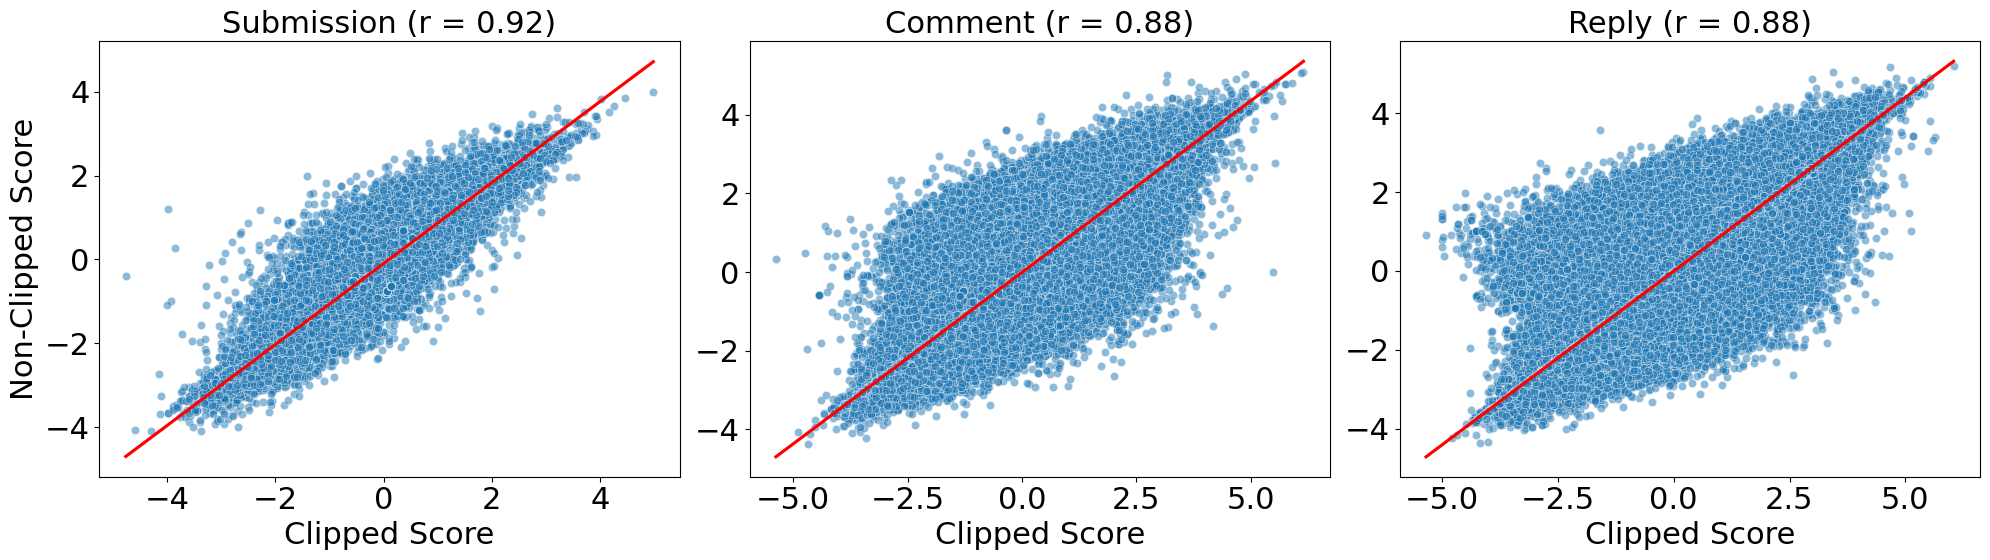

In [10]:
plot_clipped_vs_non_clipped(clipped_dict, non_clipped_dict, model_type='finetuned', order='len_EMI_z_trans')


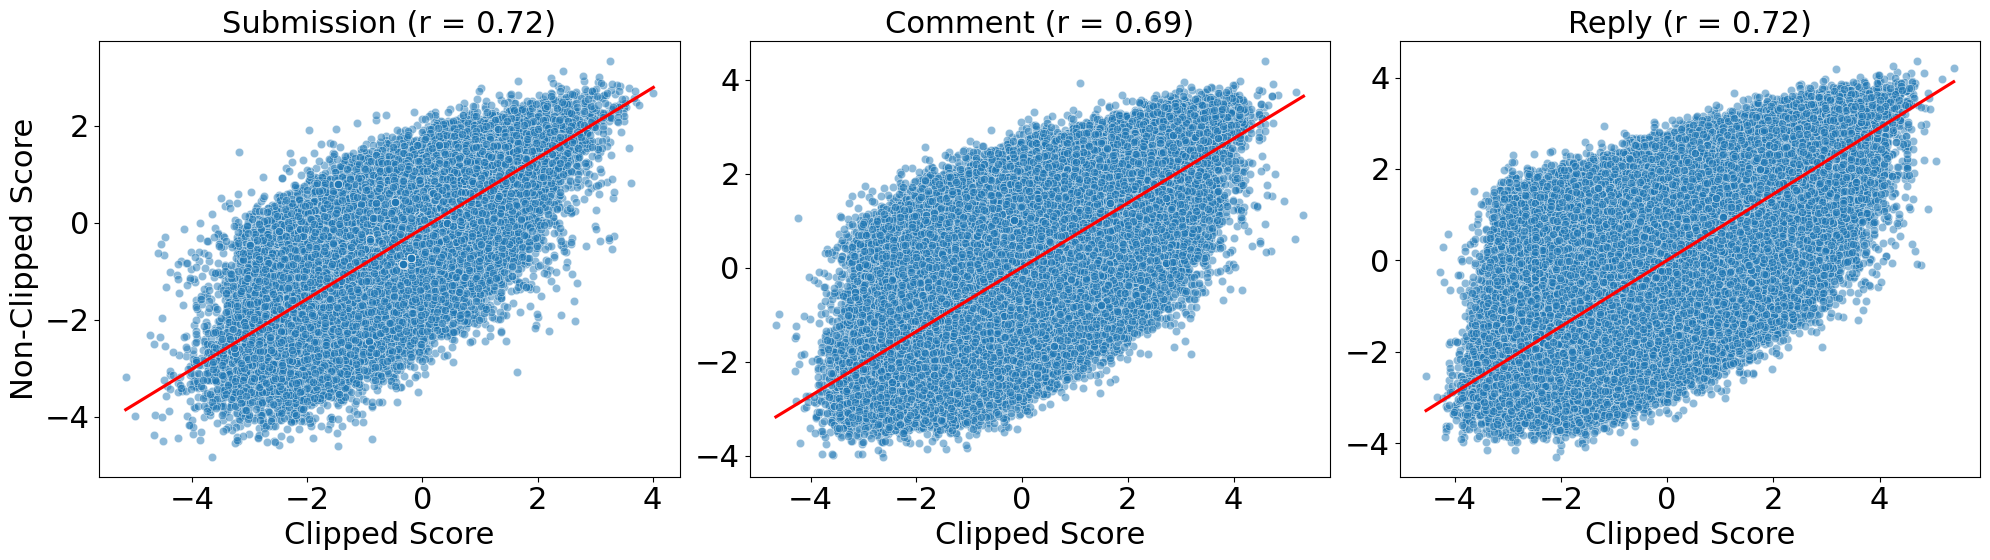

In [11]:
plot_clipped_vs_non_clipped(clipped_dict, non_clipped_dict, model_type='self', order='len_EMI_z_trans')


KeyboardInterrupt: 

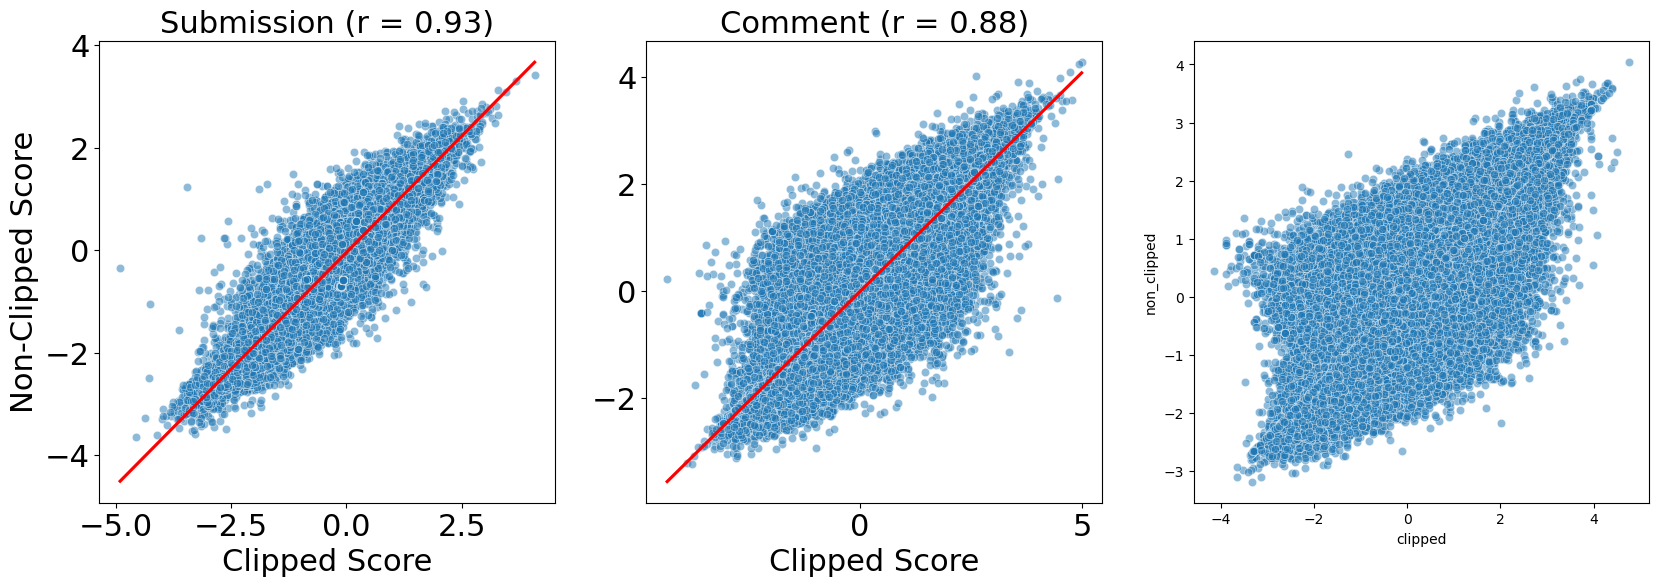

In [12]:
plot_clipped_vs_non_clipped(clipped_dict, non_clipped_dict, model_type='finetuned', order='len_norm_z_trans_EMI')


In [ ]:
plot_clipped_vs_non_clipped(clipped_dict, non_clipped_dict, model_type='self', order='len_norm_z_trans_EMI')


In [17]:

#for model in ["finetuned", "self"]:
    for text_type in ["parent", "child", "submission"]:

        print(model)
        print(text_type)
        print(np.corrcoef(Ask_Politics_clipped[f'{model}_{text_type}_len_EMI_z_trans'], Ask_Politics_non_clipped[f'{model}_{text_type}_len_EMI_z_trans'])[0][1])



IndentationError: unexpected indent (3532291611.py, line 2)

In [28]:

#for model in ["finetuned", "self"]:
    for text_type in ["parent", "child", "submission"]:

        print(model)
        print(text_type)
        print(np.corrcoef(Ask_Politics_clipped[f'{model}_{text_type}_len_norm_z_trans_EMI'], Ask_Politics_non_clipped[f'{model}_{text_type}_len_norm_z_trans_EMI'])[0][1])



finetuned
parent
0.9229400026341752
finetuned
child
0.911828705408821
finetuned
submission
0.9272440500144312
self
parent
0.6763635720323811
self
child
0.7072017922730065
self
submission
0.7035637653096581



***

# **2.) EMI and z-transform Order**

### Plot to compare the two ways of calculatring EMI

In [50]:
clipped_dict["Ask_Politics"].columns

Index(['msg_id_parent', 'msg_id_child', 'submission_id', 'subreddit',
       'exact_time_child', 'author_child', 'author_parent',
       'author_submission', 'finetuned_child_E_norm', 'finetuned_child_I_norm',
       'finetuned_parent_E_norm', 'finetuned_parent_I_norm',
       'finetuned_submission_E_norm', 'finetuned_submission_I_norm',
       'self_child_E_norm', 'self_child_I_norm', 'self_parent_E_norm',
       'self_parent_I_norm', 'self_submission_E_norm',
       'self_submission_I_norm', 'finetuned_parent_len_EMI_z_trans',
       'finetuned_child_len_EMI_z_trans',
       'finetuned_submission_len_EMI_z_trans', 'self_parent_len_EMI_z_trans',
       'self_child_len_EMI_z_trans', 'self_submission_len_EMI_z_trans',
       'finetuned_parent_len_norm_z_trans_EMI',
       'finetuned_child_len_norm_z_trans_EMI',
       'finetuned_submission_len_norm_z_trans_EMI',
       'self_parent_len_norm_z_trans_EMI', 'self_child_len_norm_z_trans_EMI',
       'self_submission_len_norm_z_trans_EMI'],


In [17]:
def plot_emi_scatter(clipped_dict, model_type='finetuned', clipping_type='clipped'):
    # Define text types in desired order and with human-readable labels
    text_types = [
        ('submission', 'submission_id', 'Submission'),
        ('parent', 'msg_id_parent', 'Comment'),
        ('child', 'msg_id_child', 'Reply')
    ]
    
    # dict to store unique DataFrames by type
    unique_data = {key: [] for key, _, _ in text_types}

    for subr, df in clipped_dict.items():
        for key, id_col, _ in text_types:
            if id_col in df.columns:
                unique_df = df.drop_duplicates(subset=[id_col])
                unique_data[key].append(unique_df)
        print(f"Extracted texts for {subr}")

    # Concatenate per-text-type DataFrames across subreddits
    for key in unique_data:
        unique_data[key] = pd.concat(unique_data[key], ignore_index=True)

    model_header = {"finetuned" : "Fine-Tuned",
                   "self" : "Self-Build"}
    
    print("Start Plotting")
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
    #plt.suptitle(f"EMI Comparison: Z-before vs Z-after\n ({model_header[model_type]}, {clipping_type})", fontsize=16)

    for ax, (key, _, label) in zip(axes, text_types):
        df = unique_data[key]
        x_col = f"{model_type}_{key}_len_EMI_z_trans"
        y_col = f"{model_type}_{key}_len_norm_z_trans_EMI"
        
        if x_col in df.columns and y_col in df.columns:
            df = df.dropna(subset=[x_col, y_col])
            sns.scatterplot(data=df, x=x_col, y=y_col, ax=ax, alpha=0.5)
            sns.regplot(data=df, x=x_col, y=y_col, ax=ax, scatter=False, color='red')

            if not df.empty:
                corr, _ = pearsonr(df[x_col], df[y_col])
                ax.set_title(f"{label} (r = {corr:.2f})", fontsize = 22)
            else:
                ax.set_title(f"{label} (no data)")
            
            ax.set_xlabel("First EMI, then z-transform", fontsize = 22)
            ax.set_ylabel("First z-transform, then EMI", fontsize = 22)
        else:
            ax.set_title(f"{label} - Missing columns")
            ax.set_axis_off()

        ax.tick_params(axis='both', labelsize=22)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"EMI_ComputeOrder_Plots/{model_type}_{clipping_type}.png",dpi =600)
    plt.show()

Extracted texts for Ask_Politics
Extracted texts for Askpolitics
Extracted texts for PoliticalDiscussion
Extracted texts for PoliticalDebate
Extracted texts for NeutralPolitics
Extracted texts for politics
Start Plotting


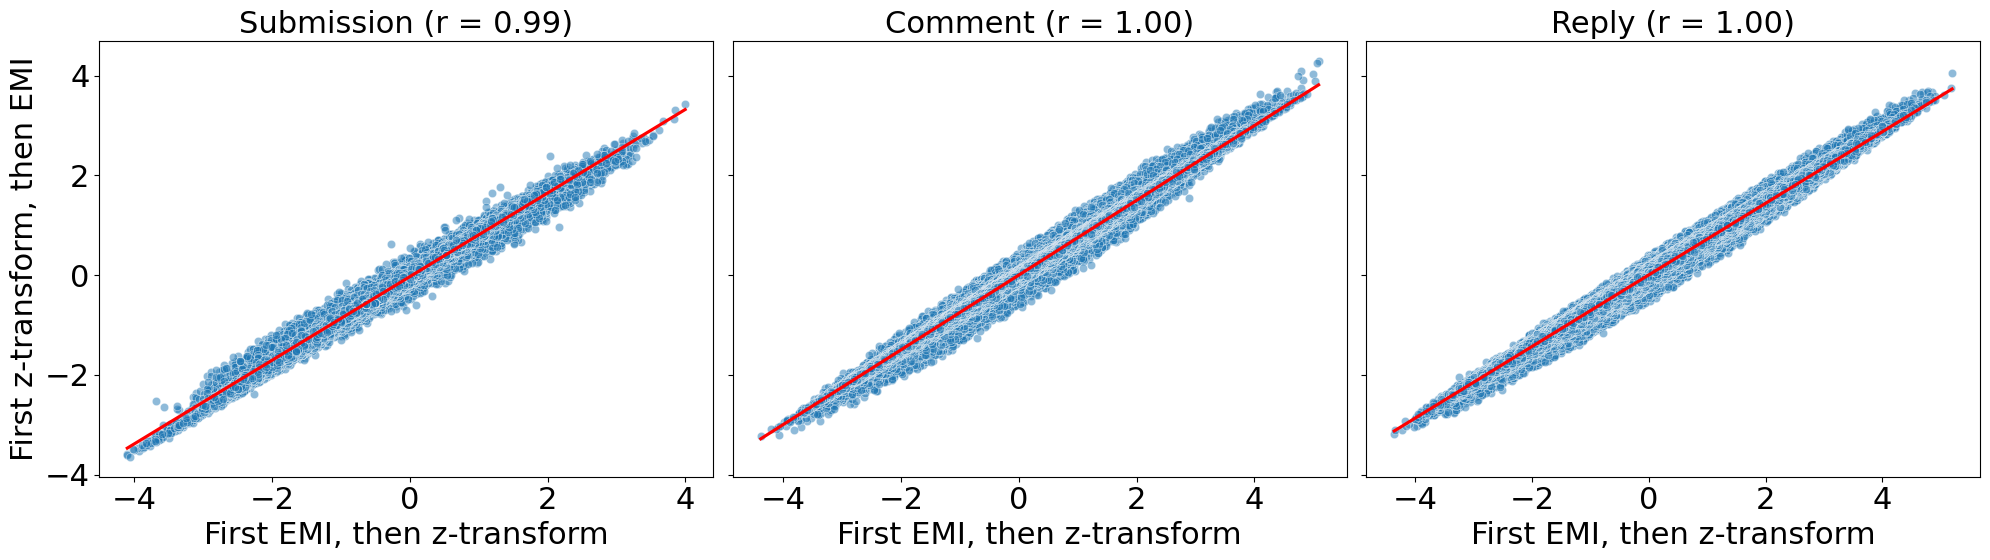

In [18]:
# non-clipped, finetuned
plot_emi_scatter(non_clipped_dict, model_type='finetuned', clipping_type = "non-clipped")

Extracted texts for Ask_Politics
Extracted texts for Askpolitics
Extracted texts for PoliticalDiscussion
Extracted texts for PoliticalDebate
Extracted texts for NeutralPolitics
Extracted texts for politics
Start Plotting


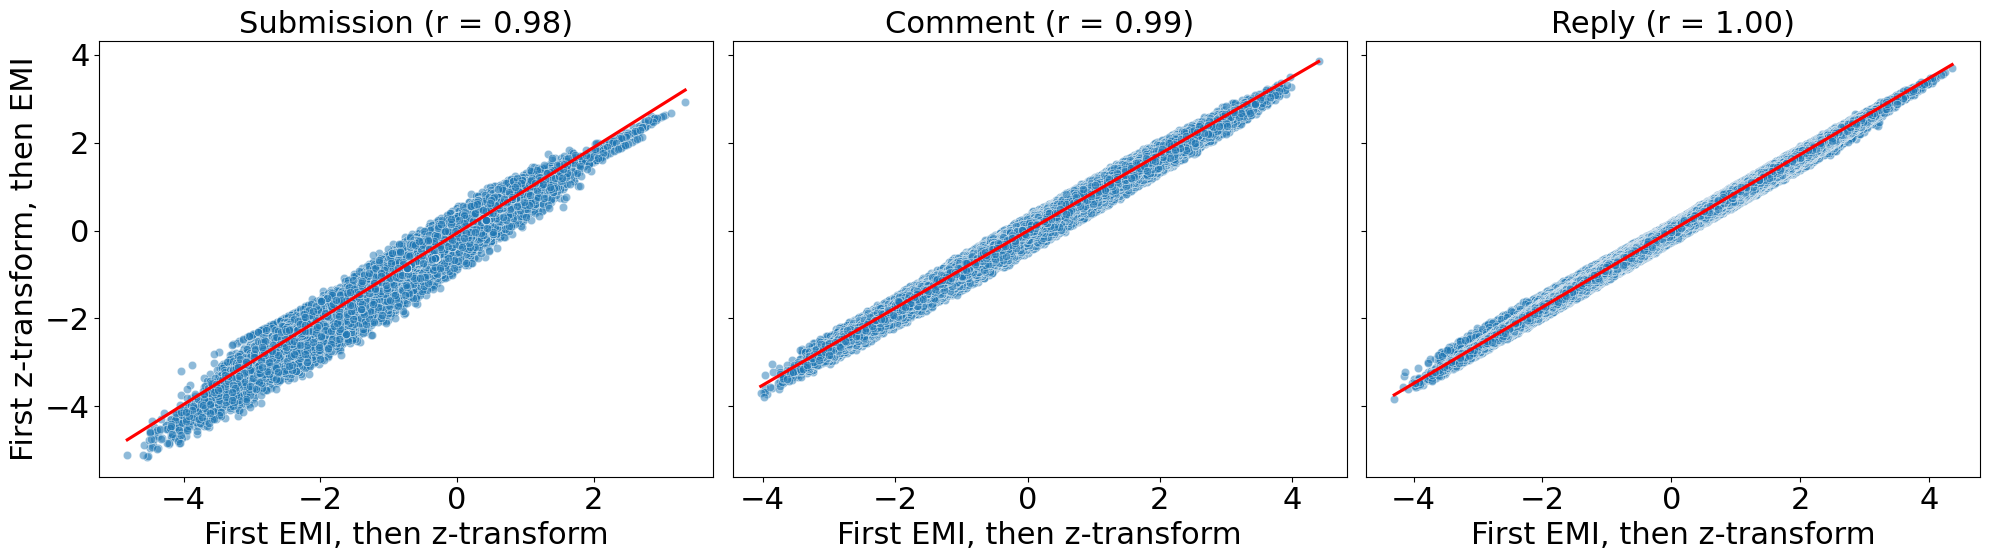

In [19]:
# non clipped, self model
plot_emi_scatter(non_clipped_dict, model_type='self', clipping_type = "non-clipped")


In [20]:
non_clipped_dict

{'Ask_Politics':       msg_id_parent msg_id_child submission_id     subreddit  \
 0           c7ecp8d      c7ecs2n        14m325  Ask_Politics   
 1           c7ecp8d      c7ecxpk        14m325  Ask_Politics   
 2           c7ecp8d      c7eflag        14m325  Ask_Politics   
 3           c7efx8q      c7ejh1d        14m325  Ask_Politics   
 4           c7efx8q      c7f8140        14m325  Ask_Politics   
 ...             ...          ...           ...           ...   
 54198       jw3iofg      k8f1j20       15frtsy  Ask_Politics   
 54199       fcyrekh      k8kje6m        ejj4xd  Ask_Politics   
 54200       k9fz0e9      k9wo2gy       17w3s8o  Ask_Politics   
 54201       k9fz0e9      kb8de02       17w3s8o  Ask_Politics   
 54202       k9n9hx4      k9xzggt       17w3s8o  Ask_Politics   
 
        exact_time_child          author_child         author_parent  \
 0          1.355167e+09             karmanaut          Ramblin_Dash   
 1          1.355167e+09          zoolander951          Ra

In [ ]:
# clipped, finetuned
plot_emi_scatter(clipped_dict, model_type='finetuned', clipping_type = "clipped")


In [ ]:
# clipped, self
plot_emi_scatter(clipped_dict, model_type='self', clipping_type = "clipped")
